AGN selections

In [1]:
import pandas as pd
import numpy as np
# import itertools as it

import pickle as pcl

from scipy.spatial.distance import cdist
from scipy.stats import binned_statistic

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [2]:
from palettable.tableau import GreenOrange_12

cmap = GreenOrange_12.hex_colors

In [3]:
import hightolowz

In [55]:
redshifts = ['2p07','3p10','3p95','5p03','5p92','6p97']
zees = [2.07,3.10,3.95,5.03,5.92,6.97]

redshiftz = [x.replace('p','.') for x in redshifts[:4]]

In [56]:
selection = 'stellarMass'

gals = [None] * len(redshifts)

for i, redshift in enumerate(redshifts):

    gals[i] = pd.read_csv('data/r200/henriques2015a_z%s_%s_r200.csv' % (redshift, selection), skiprows=122, skipfooter=1, engine='python')

    gals[i] = pd.concat([gals[i], pd.read_csv('data/r200/dgal_%s_%s_r2.5_gals.csv' % (selection, redshift))], axis=1)
    gals[i] = pd.concat([gals[i], pd.read_csv('data/r200/dgal_%s_%s_r5_gals.csv' % (selection, redshift))], axis=1)
    gals[i] = pd.concat([gals[i], pd.read_csv('data/r200/dgal_%s_%s_r7.5_gals.csv' % (selection, redshift))], axis=1)
    gals[i] = pd.concat([gals[i], pd.read_csv('data/r200/dgal_%s_%s_r10_gals.csv' % (selection, redshift))], axis=1)
    gals[i] = pd.concat([gals[i], pd.read_csv('data/r200/dgal_%s_%s_r15_gals.csv' % (selection, redshift))], axis=1)
    

In [57]:
# i = 0

# epsilon = 0.1
# c = 2.97e8 # m s^-1
# Mdot = gals[i]['zn_quasarAccretionRate'] * 1.989e30 / (365.25*24*60*60)

# Lbol = epsilon * Mdot * c**2  # J s^-1
# Lbol *= 1e7  # erg s^-1

# quasar_mask = Lbol > 1e44
# np.sum(Lbol > 1e44)

In [72]:
quasar_lim = 0.01
radio_lim = 0.001

0 2.07
1 3.10
2 3.95
3 5.03


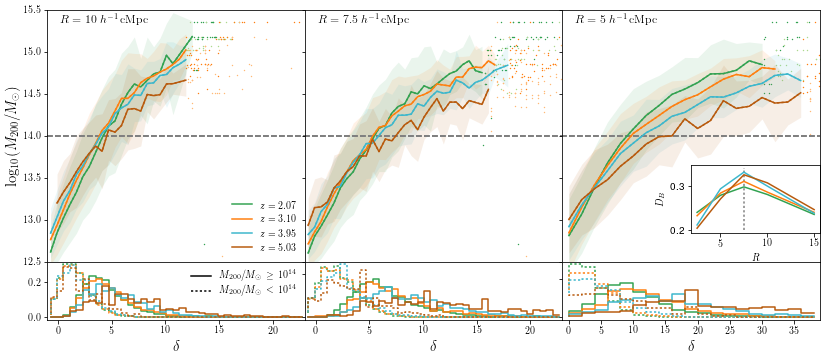

In [99]:
BinLimits = [np.linspace(-1, 11, 25), 
             np.linspace(-1, 23, 41),
             np.linspace(-1, 23, 41), 
             np.linspace(-1, 39, 21)]

Bins = [np.linspace(-0.75, 10.75, 24),
        np.linspace(-0.7, 22.7, 40), 
        np.linspace(-0.7, 22.7, 40),
        np.linspace(0, 38, 20)]

fig = plt.figure(figsize=(15,10))

gs1 = gridspec.GridSpec(32, 26)

gs1.update(bottom = 0.57, top = 1, hspace=0, wspace=0)

ax1 = fig.add_subplot(gs1[0:26,0:8])
ax5 = fig.add_subplot(gs1[26:32,0:8])

ax2 = fig.add_subplot(gs1[0:26,8:16])
ax6 = fig.add_subplot(gs1[26:32,8:16])

ax3 = fig.add_subplot(gs1[0:26,16:24])
ax7 = fig.add_subplot(gs1[26:32,16:24])

ax9 = fig.add_subplot(gs1[16:23,20:24])

Bhatta =[[] for i in range(len(redshiftz))]

radii = [10,7.5,5]

for i, redshift in enumerate(redshiftz):
    
    print i, redshift

    quasar_mask = gals[i]['zn_quasarAccretionRate'] > quasar_lim

    mask = ~np.isnan(np.log10(gals[i]['z0_central_mcrit200'] * 1e10))
    
    for axt, axb, R, binLimits, bins in zip([ax1,ax2,ax3], [ax5,ax6,ax7], radii, BinLimits[1:4], Bins[1:4]):
        
        # Subplot
        phiB, mass = np.histogram(gals[i][quasar_mask & (gals[i]['z0_central_mcrit200'] < 1e4)]['dgal_%s'%R],
                                     bins=binLimits, normed=True)
        
        
        phiA, mass = np.histogram(gals[i][quasar_mask & (gals[i]['z0_central_mcrit200'] >= 1e4)]['dgal_%s'%R],
                                 bins=binLimits, normed=True)
        
        DB, BC = hightolowz.bhattacharyya(phiA*np.diff(binLimits), phiB*np.diff(binLimits))
        
        Bhatta[i].append(DB)

        # Main Plot
        median = binned_statistic(gals[i][quasar_mask]['dgal_%s'%R][mask], 
                          np.log10(gals[i][quasar_mask]['z0_central_mcrit200'] * 1e10)[mask],
                          bins=binLimits, statistic='median')[0]

        count = binned_statistic(gals[i][quasar_mask]['dgal_%s'%R][mask], 
                                  np.log10(gals[i][quasar_mask]['z0_central_mcrit200'] * 1e10)[mask],
                                  bins=binLimits, statistic='count')[0]

        std = binned_statistic(gals[i][quasar_mask]['dgal_%s'%R][mask], 
                                 np.log10(gals[i][quasar_mask]['z0_central_mcrit200'] * 1e10)[mask],
                                 bins=binLimits, statistic='std')[0]

        cmask = (count > 10)
        
        axt.fill_between(bins[cmask], median[cmask]+std[cmask], median[cmask]-std[cmask], 
                         alpha=0.1, linewidth=0, color=cmap[i*2])
        
        axt.plot(bins[cmask], median[cmask], color=cmap[i*2], label='$z = %s$'%redshift)
        
        axt.scatter(gals[i][quasar_mask & (gals[i]['dgal_%s'%R] > max(bins[cmask]))]['dgal_%s'%R],
            np.log10(gals[i][quasar_mask & (gals[i]['dgal_%s'%R] > max(bins[cmask]))]['z0_central_mcrit200'] * 1e10),
            marker='.', s=8, c=cmap[i], lw=0, label=None)
        
        axb.set_xlim(binLimits[0], binLimits[-1])
        axt.set_xlim(binLimits[0], binLimits[-1])

        axt.plot(bins[cmask], median[cmask], color=cmap[i*2], linestyle='dotted')

        axt.hlines(14, -10, 60, linestyle='--', color='grey')
        
        axt.set_xticklabels([])

        axb.step(bins, phiA, color=cmap[i*2], alpha=1)# + i*0.1)
        axb.step(bins, phiB, color=cmap[i*2], linestyle='dotted', alpha=1)# + i*0.1)

        phi, mass = np.histogram(gals[i]['dgal_%s'%R], bins=binLimits, normed=True)

        if(i==0):
            axt.text(0.05, 0.95, '$R = %s \; h^{-1} \, \mathrm{cMpc}$'%R, transform=axt.transAxes, size=12)


## Calculate R = 15 & 2.5 Bhattacharya distance, but don't plot
for i, redshift in enumerate(redshiftz):
    for R, switch in zip([15,2.5],[True,False]):
    
        phiB, mass = np.histogram(gals[i][quasar_mask & (gals[i]['z0_central_mcrit200'] < 1e4)]['dgal_%s'%R],
                                     bins=binLimits, normed=True)
        phiA, mass = np.histogram(gals[i][quasar_mask & (gals[i]['z0_central_mcrit200'] >= 1e4)]['dgal_%s'%R],
                                 bins=binLimits, normed=True)
        DB, BC = hightolowz.bhattacharyya(phiA*np.diff(binLimits), phiB*np.diff(binLimits))
        
        if switch:
            Bhatta[i] = [DB] + Bhatta[i]
        else:
            Bhatta[i].append(DB)
        

for i,z in enumerate(redshiftz):
    ax9.plot([15] + radii + [2.5], Bhatta[i], color=cmap[i*2])
    
ax9.set_xlabel('$R$')
ax9.set_ylabel('$D_{B}$')

# ax9.set_xticklabels([4,6,8,10,12,14,16,18,''])
ax9.set_yticklabels(['',0.2,0.3,0.4,0.5,0.6,0.7,''])

ax9.vlines(7.5, 0, 0.7, colors='grey', linestyles='dotted')

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_ylim(12.5,15.5)

## Legend
line1 = plt.Line2D((0,1),(0,0), color='black', linestyle='solid')
line2 = plt.Line2D((0,1),(0,0), color='black', linestyle='dotted')

ax5.legend(handles=[line1, line2], 
           labels=[r'$M_{200} / M_{\odot} \, \geq \, 10^{14}$',
                   r'$M_{200} / M_{\odot} \, < \, 10^{14}$'], 
           loc=1, prop={'size':10}, frameon=False)

ax1.legend(loc=4, frameon=False)

for ax in [ax2,ax3,ax6,ax7]:
    ax.set_yticklabels([])

for ax in [ax5,ax6,ax7]:
    ax.set_xlabel('$\delta$', size=15, ha='center')

ax1.set_ylabel('$\mathrm{log_{10}}(M_{200} / M_{\odot})$',va='center',size=15,rotation='vertical',labelpad=8)  

# plt.savefig('../papers/protoclusters/images/quasar_select.png', bbox_inches='tight', dpi=300)

In [178]:
BinLimits = [np.linspace(-1, 11, 13), 
             np.linspace(-1, 26, 16),
             np.linspace(-1, 26, 16), 
             np.linspace(-1, 39, 21)]

Bins = [np.linspace(-0.5, 10.5, 12),
        np.linspace(-0.1, 25.1, 15), 
        np.linspace(-0.1, 25.1, 15),
        np.linspace(0, 38, 20)]

In [179]:
i = 1
print BinLimits[i]
print Bins[i]

[ -1.    0.8   2.6   4.4   6.2   8.    9.8  11.6  13.4  15.2  17.   18.8
  20.6  22.4  24.2  26. ]
[ -0.1   1.7   3.5   5.3   7.1   8.9  10.7  12.5  14.3  16.1  17.9  19.7
  21.5  23.3  25.1]


0 2.07
1 3.10
2 3.95
3 5.03
[ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.]
[ 0.   0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0. ]
[ 0.18478261  0.27173913  0.0326087   0.01086957  0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]


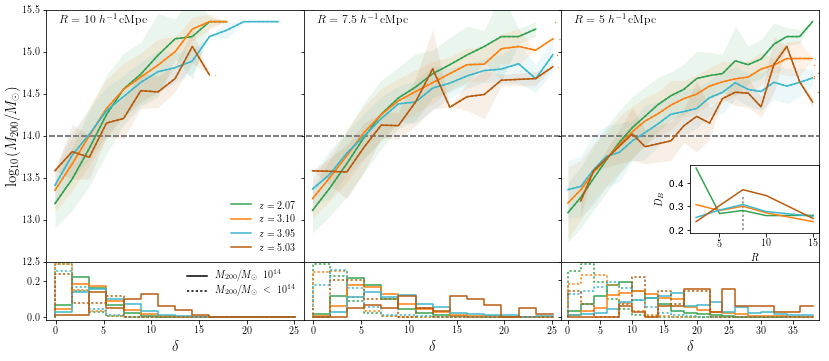

In [202]:
fig = plt.figure(figsize=(15,10))

gs1 = gridspec.GridSpec(32, 26)

gs1.update(bottom = 0.57, top = 1, hspace=0, wspace=0)

ax1 = fig.add_subplot(gs1[0:26,0:8])
ax5 = fig.add_subplot(gs1[26:32,0:8])

ax2 = fig.add_subplot(gs1[0:26,8:16])
ax6 = fig.add_subplot(gs1[26:32,8:16])

ax3 = fig.add_subplot(gs1[0:26,16:24])
ax7 = fig.add_subplot(gs1[26:32,16:24])

ax9 = fig.add_subplot(gs1[16:23,20:24])

Bhatta =[[] for i in range(len(redshiftz))]

radii = [10,7.5,5]

for i, redshift in enumerate(redshiftz):
    
    print i, redshift

    radio_mask = gals[i]['zn_radioAccretionRate'] > radio_lim

    mask = ~np.isnan(np.log10(gals[i]['z0_central_mcrit200'] * 1e10))
    
    for axt, axb, R, binLimits, bins in zip([ax1,ax2,ax3], [ax5,ax6,ax7], radii, BinLimits[1:4], Bins[1:4]):
        
        # Subplot
        phiB, mass = np.histogram(gals[i][radio_mask & (gals[i]['z0_central_mcrit200'] < 1e4)]['dgal_%s'%R],
                                     bins=binLimits, normed=True)
        
        
        phiA, mass = np.histogram(gals[i][radio_mask & (gals[i]['z0_central_mcrit200'] >= 1e4)]['dgal_%s'%R],
                                 bins=binLimits, normed=True)
        
        DB, BC = hightolowz.bhattacharyya(phiA*np.diff(binLimits), phiB*np.diff(binLimits))
        
        Bhatta[i].append(DB)
        
        axb.set_xlim(binLimits[0], binLimits[-1])
        axt.set_xlim(binLimits[0], binLimits[-1])

        # Main Plot
        median = binned_statistic(gals[i][radio_mask]['dgal_%s'%R][mask], 
                          np.log10(gals[i][radio_mask]['z0_central_mcrit200'] * 1e10)[mask],
                          bins=binLimits, statistic='median')[0]

        count = binned_statistic(gals[i][radio_mask]['dgal_%s'%R][mask], 
                                  np.log10(gals[i][radio_mask]['z0_central_mcrit200'] * 1e10)[mask],
                                  bins=binLimits, statistic='count')[0]

        std = binned_statistic(gals[i][radio_mask]['dgal_%s'%R][mask], 
                                 np.log10(gals[i][radio_mask]['z0_central_mcrit200'] * 1e10)[mask],
                                 bins=binLimits, statistic='std')[0]

        cmask = (count > 0)
        
        if np.sum(cmask) == 0:
            print 'not enough radio galaxies...'
        else:
            axt.fill_between(bins[cmask], median[cmask]+std[cmask], median[cmask]-std[cmask], 
                             alpha=0.1, linewidth=0, color=cmap[i*2])

            axt.plot(bins[cmask], median[cmask], color=cmap[i*2], label='$z = %s$'%redshift)

            axt.scatter(gals[i][radio_mask & (gals[i]['dgal_%s'%R] > max(bins[cmask]))]['dgal_%s'%R],
                np.log10(gals[i][radio_mask & (gals[i]['dgal_%s'%R] > max(bins[cmask]))]['z0_central_mcrit200'] * 1e10),
                marker='.', s=8, c=cmap[i], lw=0, label=None)

            axt.plot(bins[cmask], median[cmask], color=cmap[i*2], linestyle='dotted')

            axt.hlines(14, -10, 60, linestyle='--', color='grey')

            axt.set_xticklabels([])

            axb.step(bins, phiA, color=cmap[i*2], alpha=1)# + i*0.1)
            axb.step(bins, phiB, color=cmap[i*2], linestyle='dotted', alpha=1)# + i*0.1)

            phi, mass = np.histogram(gals[i]['dgal_%s'%R], bins=binLimits, normed=True)

        if(i==0):
            axt.text(0.05, 0.95, '$R = %s \; h^{-1} \, \mathrm{cMpc}$'%R, transform=axt.transAxes, size=12)


## Calculate R = 2.5 Mpc/h Bhattacharya distance, but don't plot
for i, redshift in enumerate(redshiftz):
    for R, switch in zip([15,2.5],[True,False]):
        phiB, mass = np.histogram(gals[i][radio_mask & (gals[i]['z0_central_mcrit200'] < 1e4)]['dgal_%s'%R],
                                     bins=binLimits, normed=True)
        phiA, mass = np.histogram(gals[i][radio_mask & (gals[i]['z0_central_mcrit200'] >= 1e4)]['dgal_%s'%R],
                                 bins=binLimits, normed=True)
        DB, BC = hightolowz.bhattacharyya(phiA*np.diff(binLimits), phiB*np.diff(binLimits))
        
        if (R == 15) & (i == 0):
            print np.diff(binLimits)
            print phiA
            print phiB
        
        if switch:
            Bhatta[i] = [DB] + Bhatta[i]
        else:
            Bhatta[i].append(DB)
            
for i,z in enumerate(redshiftz):
    ax9.plot([15]+radii+[2.5], Bhatta[i], color=cmap[i*2])
    
ax9.set_xlabel('$R$')
ax9.set_ylabel('$D_{B}$')

# ax9.set_xticklabels([4,6,8,10,12,14,16,18,''])
ax9.set_yticklabels(['',0.2,0.3,0.4,0.5,0.6,0.7,''])

ax9.vlines(7.5, 0, 0.7, colors='grey', linestyles='dotted')

for ax in [ax1, ax2, ax3]:
    ax.set_ylim(12.5,15.5)

## Legend
line1 = plt.Line2D((0,1),(0,0), color='black', linestyle='solid')
line2 = plt.Line2D((0,1),(0,0), color='black', linestyle='dotted')

ax5.legend(handles=[line1, line2], 
           labels=[r'$M_{200} / M_{\odot} \; \geqslant \; 10^{14}$',
                   r'$M_{200} / M_{\odot} \; < \; 10^{14}$'], 
           loc=1, prop={'size':10}, frameon=False)

ax1.legend(loc=4, frameon=False)

ax2.set_yticklabels([])
ax4.set_yticklabels([])

ax6.yaxis.tick_right()
ax8.yaxis.tick_right()

for ax in [ax2,ax3,ax6,ax7]:
    ax.set_yticklabels([])

for ax in [ax5,ax6,ax7]:
    ax.set_xlabel('$\delta$', size=15, ha='center')

ax1.set_ylabel('$\mathrm{log_{10}}(M_{200} / M_{\odot})$',va='center',size=15,rotation='vertical',labelpad=7)  

# plt.savefig('../papers/protoclusters/images/radio_select.png', bbox_inches='tight', dpi=300)

In [183]:
from periodic_kdtree import PeriodicCKDTree

def calc_agn_frac(gals, L):

    cluster_ids = pd.unique(gals[gals['z0_central_mcrit200'] > 1e4]['z0_centralId'])
    
    N_quasar = [None] * len(cluster_ids)
    N_radio = [None] * len(cluster_ids)

    dimensions = np.array([L, L, L])

    print "Building periodic KDtree..."
    T = PeriodicCKDTree(dimensions, gals[['zn_x','zn_y','zn_z']])
    
    print "Looping through clusters..."    
    for i, cluster in enumerate(cluster_ids):
        
#         Mdot = gals[gals['z0_centralId']==cluster]['zn_quasarAccretionRate'] * 1.989 * 10**30 / (365.25*24*60*60)
#         Lbol = epsilon * Mdot * c**2 / 1e-7  # erg s^-1
#         N_agn[i] = np.sum(Lbol > 1e44)
        quasar_mask = gals[gals['z0_centralId']==cluster]['zn_quasarAccretionRate'] > quasar_lim
        radio_mask = gals[gals['z0_centralId']==cluster]['zn_radioAccretionRate'] > radio_lim
        
        N_quasar[i] = np.sum(quasar_mask)
        N_radio[i] = np.sum(radio_mask)
        
    return N_quasar, N_radio, len(cluster_ids)

In [197]:
n_quasar = [None] * len(redshifts)
n_radio = [None] * len(redshifts)
n_clust = [None] * len(redshifts)

for i,z in enumerate(redshifts):
    n_quasar[i], n_radio[i], n_clust[i] = calc_agn_frac(gals[i], 480.279)

Building periodic KDtree...
Looping through clusters...
Building periodic KDtree...
Looping through clusters...
Building periodic KDtree...
Looping through clusters...
Building periodic KDtree...
Looping through clusters...
Building periodic KDtree...
Looping through clusters...
Building periodic KDtree...
Looping through clusters...


In [198]:
quasar_in_pcs = [None] * len(gals)
radio_in_pcs = [None] * len(gals)

all_quasar = [None] * len(gals)
all_radio = [None] * len(gals)

for i in range(len(gals)):
    clust = gals[i]['z0_central_mcrit200'] > 1e4
    
#     Mdot = gals[i]['zn_quasarAccretionRate'] * 1.989 * 10**30 / (365.25*24*60*60)
#     Lbol = epsilon * Mdot * c**2 / 1e-7  # erg s^-1
#     agn_in_pcs[i] = float(np.sum((Lbol > 1e44) & clust))
#     all_agn[i] = np.sum(Lbol > 1e44)

    quasar_mask = gals[i]['zn_quasarAccretionRate'] > quasar_lim
    radio_mask = gals[i]['zn_radioAccretionRate'] > radio_lim

    quasar_in_pcs[i] = float(np.sum((quasar_mask & clust)))
    radio_in_pcs[i] = float(np.sum((radio_mask & clust)))
    
    all_quasar[i] = np.sum(quasar_mask)
    all_radio[i] = np.sum(radio_mask)

In [212]:
n_clust = np.array(n_clust)
n_clust

array([2136, 2136, 2136, 2136, 2087, 1602])

In [207]:
np.array([np.sum([x > 0 for x in y]) for y in n_quasar])

array([1579, 1384,  939,  358,  106,   26])

In [209]:
np.array([np.sum([x > 0 for x in y]) for y in n_radio])

array([2114, 1413,  458,   43,    5,    0])

In [214]:
np.array([float(np.sum([x > 0 for x in y])) for y in n_quasar]) / n_clust

array([ 0.73923221,  0.64794007,  0.43960674,  0.167603  ,  0.05079061,
        0.01622971])

/home/chris/anaconda/envs/cosmo/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in divide


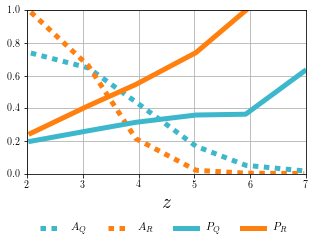

In [264]:
fig, ax = plt.subplots(1,1, figsize=(5,3))

ax.plot(zees, np.array([float(np.sum([x > 0 for x in y])) for y in n_quasar]) / n_clust, 
         label='$A_{Q}$', c=cmap[4], lw=5, linestyle='dotted')

ax.plot(zees, np.array([float(np.sum([x > 0 for x in y])) for y in n_radio]) / n_clust, 
         label='$A_{R}$', c=cmap[2], lw=5, linestyle='dotted')

ax.plot(zees, np.array(quasar_in_pcs)/np.array(all_quasar), c=cmap[4], label='$P_{Q}$', lw=5)
ax.plot(zees, np.array(radio_in_pcs)/np.array(all_radio), c=cmap[2], label='$P_{R}$', lw=5)

ax.set_xlabel('$z$', size=20)

ax.legend(frameon=False, prop={'size':11}, loc=(0.03, -0.4), ncol=4)

ax.set_xlim(2,7)
ax.grid()
ax.set_ylim(0, 1)

# plt.savefig('../papers/protoclusters/images/agn_stats.png', bbox_inches='tight', dpi=300)